<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC3</p>
<p style="margin: 0; text-align:right;">2017-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Mètodes supervisats

En aquesta pràctica veurem diferents mètodes supervisats aplicats sobre el conjunt de dades [EMNIST](https://www.nist.gov/itl/iad/image-group/emnist-dataset) i després aplicarem una xarxa neuronal (que típicament s'utilitza en problemes supervisats) en un problema amb dades no etiquetades.

<ol start="0">
  <li>Càrrega de dades</li>
  <li>$k$ veïns més propers</li>
  <li>Support vector machines</li>
  <li>Xarxes neuronals</li>
  <li>Aprenentatge no supervisat amb xarxes neuronals</li>
</ol>

**Important: Cadascun dels exercicis pot suposar varis minuts d'execució, pel que l'entrega s'ha de fer en format notebook i en format html on es vegi el codi i els resultats, juntament amb els comentaris de cada exercici. Per exportar el notebook a html es pot fer des del menú File $\to$ Download as $\to$ HTML.**

## 0. Càrrega de dades

El conjunt de dades EMNIST consisteix en diversos subconjunts de dades amb caràcters i dígits escrits a mà. Per a aquesta pràctica utilitzarem únicament un subconjunt de 5.000 imatges que consisteix en 1.000 imatges de 5 classes diferents ("A", "B", "C", "D" i "E").

Les imatges tenen una resolució de 28x28 píxels en escala de grisos, pel que es poden representar utilitzant un vector de 784 posicions.

El següent codi carregarà les 5.000 imatges en la variable *images* i les corresponents etiquetes (en forma numèrica) en la variable *labels*. Podem comprovar que la càrrega ha estat satisfactòria obtenint les dimensions d'aquestes dues variables.

In [1]:
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["A", "B", "C", "D", "E"]

print("Dimensions del vector d'imatges: {}".format(images.shape))
print("Dimensions del vector d'etiquetes: {}".format(labels.shape))

Dimensions del vector d'imatges: (5000, 784)
Dimensions del vector d'etiquetes: (5000,)


Amb el següent codi podem veure un exemple d'imatge de cada una de les classes. Per fer això, ajustem el vector de 784 dimensions que representa cada imatge en una matriu de mida 28x28 i la transposem per a mostrar-la:

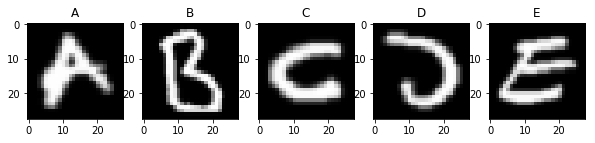

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28).transpose(), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

De les 5.000 imatges diferents utilitzarem 4.000 imatges per a entrenar els diferents models i 1.000 imatges per a validar els resultats. Amb el següent codi separem les dades que hem carregat anteriorment en dos conjunts, train i test, de forma estratificada, és a dir, en cada un dels dos conjunts les classes apareixen representades en la mateixa proporció que al conjunt de dades original.

En lloc de treballar direcament amb un vector de 784 dimensions per a cada imatge, aplicarem primer l'algoritme PCA per a reduir la dimensió dels exemples a 100. El procès d'entrenament de PCA el fem només amb les imatges de train i després l'apliquem també sobre les imatges de test, de forma que utilitzem en cap cas informació de les imatges en el conjunt de test per a entrenar els models.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=2017, stratify=labels)

pca = PCA(n_components=100, random_state=2017)
pca_fit = pca.fit(X_train)
X_train_pca = pca_fit.transform(X_train)
X_test_pca = pca_fit.transform(X_test)


def proporcio_etiquetes(y):
    _, count = np.unique(y, return_counts=True)
    return np.true_divide(count, y.shape[0])
    

print("Número d'imatges per a entrenar: {}".format(X_train_pca.shape[0]))
print("Número d'imatges per a test: {}".format(X_test_pca.shape[0]))

print("Proporció de les etiquetes en el conjunt original: {}".format(proporcio_etiquetes(labels)))
print("Proporció de les etiquetes en el conjunt d'entrenament: {}".format(proporcio_etiquetes(y_train)))
print("Proporció de les etiquetes en el conjunt de test: {}".format(proporcio_etiquetes(y_test)))

Número d'imatges per a entrenar: 4000
Número d'imatges per a test: 1000
Proporció de les etiquetes en el conjunt original: [0.2 0.2 0.2 0.2 0.2]
Proporció de les etiquetes en el conjunt d'entrenament: [0.2 0.2 0.2 0.2 0.2]
Proporció de les etiquetes en el conjunt de test: [0.2 0.2 0.2 0.2 0.2]


## 1. $k$ veïns més propers (2 punts)

El primer algoritme que utilitzarem per a classificar les imatges de les lletres és el $k$-nn. En aquest exercici ajustarem dos hiperparàmetres del algoritme:

- $k$: el número de veïns que es consideren per a classificar un nou exemple. Provarem amb tots els valors entre 1 i 10.
- pesos: importància que es dona a cadascun dels veïns considerats. En aquest cas provarem amb dues opcions: pesos uniformes, on tots els veïns es consideren igual; i pesos segons distància, on els veïns més propers tenen més pes en la classificació que els veïns més llunyans.

Per a decidir quins són els hiperparàmetres òptims utilitzarem una cerca de reixeta (grid search), és a dir, entrenarem un model per a cada combinació de hiperparàmetres possible i la evaluarem utilitzant validació creuada (cross validation) amb 4 particions estratificades. Posteriorment, triarem la combinació d'hiperparàmetres que millors resultats hagi obtingut.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> càlcul del valor òptim dels hiperparàmetres $k$ i $ pesos. Podeu utilitzar els mòduls GridSearchCV i KNeighborsClassifier de sklearn.
</div>

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# creating odd list of K for KNN
k_range = list(range(1, 10))

# we create a list
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)
knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=4, random_state=111111, shuffle=True)
grid = GridSearchCV(
    knn,
    param_grid,
    cv=cv,
    scoring='accuracy'
)
grid.fit(X_train_pca, y_train)

print("La millor puntuació és %s" % grid.best_score_)
print("El mètode òptim amb el nombre de veïns és ")
print(grid.best_params_)

La millor puntuació és 0.9485
El mètode òptim amb el nombre de veïns és 
{'n_neighbors': 4, 'weights': 'distance'}


Com podem veure els valors òptims del hiperparàmetres per k=4 i els pesos segons la proximtat, mètode "distance". Ho podem representar gràficament per la millor puntuació:

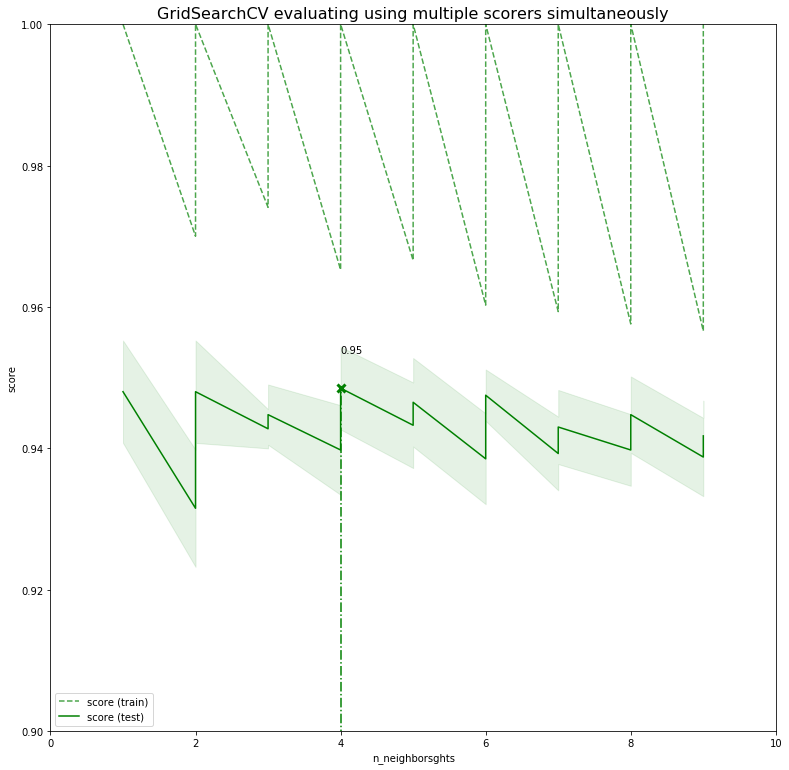

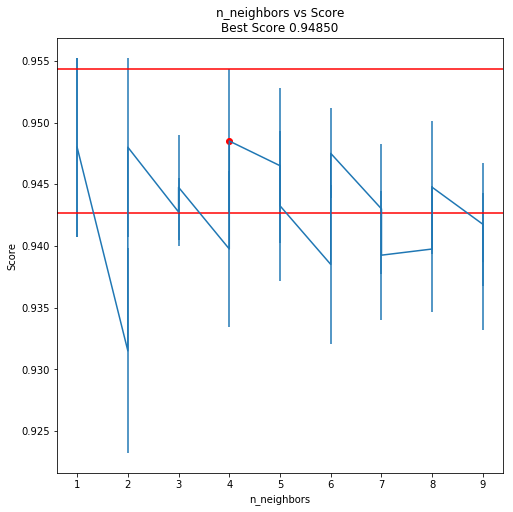

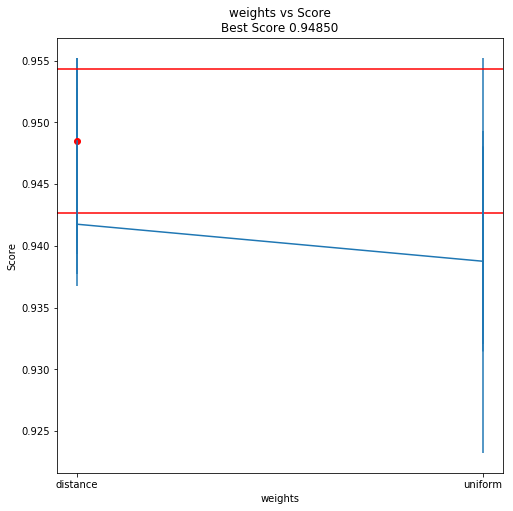

In [5]:
import pandas as pd

results = grid.cv_results_
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("n_neighborsghts")
plt.ylabel("score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, 10)
ax.set_ylim(0.90, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_neighbors'].data, dtype=float)

for scorer, color in zip(sorted(['score']), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()


def grid_search_table_plot(param_name,
                          negative=True,
                          graph=True):
    scores_df = pd.DataFrame(results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']

    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(best_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()


grid_search_table_plot("n_neighbors", negative=False)
grid_search_table_plot("weights", negative=False)


Per veure mes facilment la diferencia entre donar pesos uniformement o segons ditancia dels veins podem fer manualment una representació grafica per comparar, amb l'anterior es molt complex per poder representar graficament:

El nombre òptim de veïns és 3 amb uniform 
El nombre òptim de veïns és 4 amb distance 


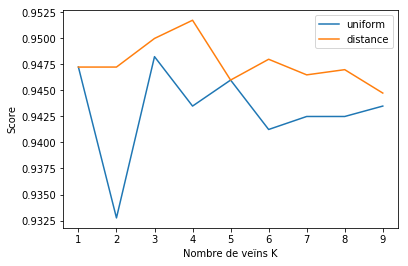

In [6]:
# creating odd list of K for KNN
myList = list(range(1, 10))

weight_options = ['uniform', 'distance']

for weight in weight_options:
    # empty list that will hold cv scores
    cv_scores = []
    # perform 10-fold cross validation with neighbors distance
    for k in myList:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
        scores = cross_val_score(knn, X_train_pca, y_train, cv=4, scoring='accuracy')
        cv_scores.append(scores.mean())

    # determining best k
    optimal_k = myList[cv_scores.index(max(cv_scores))]
    print("El nombre òptim de veïns és %d amb %s " % (optimal_k, weight))

    # plot misclassification error vs k
    plt.plot(myList, cv_scores, label=weight)

plt.legend()
plt.xlabel('Nombre de veïns K')
plt.ylabel('Score')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

Amb aquest últim gràfic ho podem veure clarament, ha donat millor resultat el cross validation quan s'ha donat un pes o importància a cadascun dels veïns per la seva proximitat, els veïns més propers tenen més pes i k=4, donada la puntuació d'encerts més alta 0.9444 quasi un 0.95.

Pel que fa a les variacions, sí que produeix diferencia entre la combinació de paràmetres com podem veure en el gràfic, per exemple quan els valors tenen pesos uniformes i el valor de k és 3 el nombre d'encerts baixa fins a un 93 per cent. Per tant, hi ha diferencia entre combinacions.

Pel que la influència dels paràmetres, el hiperparàmetre del pes és molt important, mes que el nombre de particions, tot i aquest segons es significatiu quan el pes assignat és uniforme.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> entrenar un model $k$-nn amb els valors dels hiperparàmetres òptims utilitzant tot el conjunt *X_train_pca* i mostrar la precisió de la predicció del model en el conjunt *X_test_pca*.
</div>

In [7]:
# instantiate learning model (k = 4) with optimal_k
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

# fitting the model
knn.fit(X_train_pca, y_train)

# predict the response
pred = knn.predict(X_test_pca)

# evaluate accuracy
accuracy = accuracy_score(y_test, pred)
print(accuracy)
print('\nLa precisió del nostre classificador és %d%%' % (accuracy * 100))

0.944

La precisió del nostre classificador és 94%


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> mostrar la matriu de confusió del model i algunes imatges que el model hagi classificat incorrectament juntament amb l'etiqueta assignada pel model i l'etiqueta original.
</div>

[[199   0   0   1   0]
 [  5 166   6  10  13]
 [  0   0 197   0   3]
 [  3   0   2 194   1]
 [  1   0  11   0 188]]


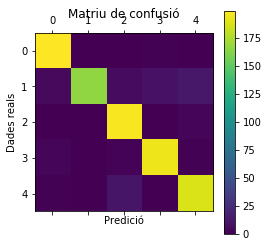

Imprimim algunes de les imatges que no s'han classificat correctament:


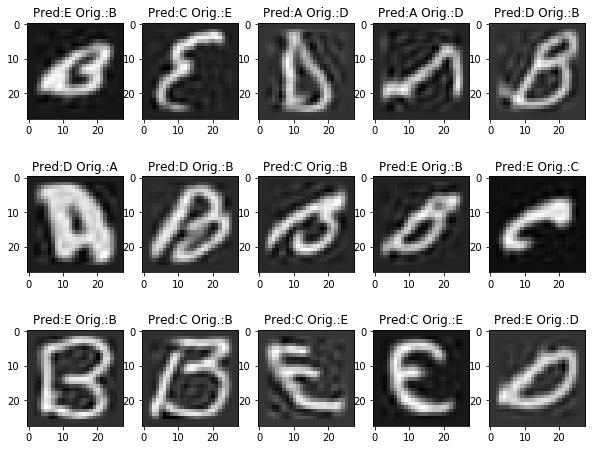

In [8]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
print(cm)

# representem graficament
plt.matshow(cm)
plt.title('Matriu de confusió')
plt.colorbar()
plt.ylabel('Dades reals')
plt.xlabel('Predició')
plt.show()

Error_list_index = [i for i, (j, k) in enumerate(zip(y_test, pred)) if j != k]

print('Imprimim algunes de les imatges que no s\'han classificat correctament:')

n_images = 5
fields = 3

fig, ax = plt.subplots(fields, n_images, figsize=(10, 8))

for y in range(fields):
    x = 0
    for i in range(y * n_images, y * n_images + n_images):
        k = Error_list_index[i]
        image = pca.inverse_transform(X_test_pca[k])
        ax[y][x].imshow(image.reshape(28, 28).transpose(), cmap="gray")
        ax[y][x].set_title("Pred:%s Orig.:%s" % (labels_text[pred[k]], labels_text[y_test[k]]))
        x = x + 1

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Com són els errors? Semblen raonables?
</div>

Si, els errors pareixen raonables, podem veure que són caràcters que tenen certa inclinació, si pensem en algoritme del knn i les 4 capes d'estratificació és fàcil entendre, observen la forma, que hi hagi seleccionat la lletra en la predició degut a la seva semblança com E i B si tracem cercles.

## 2. Support Vector Machines (2 punts)

En aquest segon exercici classificarem les imatges de les lletres utilitzant l'algoritme SVM amb el kernel radial. En aquest cas, en lloc d'utilitzar una cerca de reixeta per ajustar els hiperparàmetres de l'algoritme utilitzarem una cerca aleatòria, és a dir, provarem combinacions de paràmetres a l'atzar. Els hiperparàmetres a optimitzar són:

- C: el valor de penalització dels errors en la classificació. Indica el compromís entre obtenir l'hiperpla amb el marge més gran possible i classificar el màxim número d'exemples correctament. Provarem valors aleatoris distribuits uniformement entre 1 i 500.
- gamma: coeficient que multiplica la distància entre dos punts al kernel radial. Provarem valors aleatoris distribuits uniformement entre $10^{-9}$ i $10^{-5}$.

Igual que en el cas anterior, per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres utilitzarem validació creuada (cross-validation) amb 4 particions estratificades.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> càlcul del valor òptim dels hiperparàmetres C i gamma utilitzant 10 combinacions de paràmetres triades a l'atzar. Podeu utilitzar els mòduls RandomizedSearchCV i svm de sklearn, així com el mòdul uniform de scipy.
</div>

In [9]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

# Combinatoria de valors que usarem per la funció arange i logspace
param_distributions = {
    'C': np.arange(1, 500 + 1, 1).tolist(),
    'kernel': ['rbf'],
    'gamma': np.logspace(-9, -5, 5).tolist()
}

# Amb la funció RandomizedSearchCV generarem els números aleatoris a partir dels valors anteriors
model_randomized_search_cv = RandomizedSearchCV(
    estimator=svm.SVC(),
    param_distributions=param_distributions,
    n_iter=10
)

model_randomized_search_cv.fit(X_train, y_train)

print(model_randomized_search_cv.best_estimator_)
print(model_randomized_search_cv.best_score_)
print(model_randomized_search_cv.best_params_)

SVC(C=268, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.96575
{'kernel': 'rbf', 'gamma': 1e-07, 'C': 268}


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

Pel que fa als valors optims generats per als paràmetres C i gamma, respectivament, són 268 i 1e-07. Per altra banda generarem una funció per poder obtenir els 5 valors millors dels paràmetres anteriors:

In [10]:
def create_list_top_rank(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


create_list_top_rank(model_randomized_search_cv.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.966 (std: 0.003)
Parameters: {'kernel': 'rbf', 'gamma': 1e-07, 'C': 268}

Model with rank: 1
Mean validation score: 0.966 (std: 0.003)
Parameters: {'kernel': 'rbf', 'gamma': 1e-07, 'C': 421}

Model with rank: 3
Mean validation score: 0.945 (std: 0.004)
Parameters: {'kernel': 'rbf', 'gamma': 1e-09, 'C': 105}

Model with rank: 4
Mean validation score: 0.939 (std: 0.001)
Parameters: {'kernel': 'rbf', 'gamma': 1e-09, 'C': 337}

Model with rank: 5
Mean validation score: 0.934 (std: 0.003)
Parameters: {'kernel': 'rbf', 'gamma': 1e-08, 'C': 187}



Representem gràficament el resultat anterior del model, la mitjana i desviació estàndard, amb els paràmetres òptims de gamma i C, per poder observar el comportament:

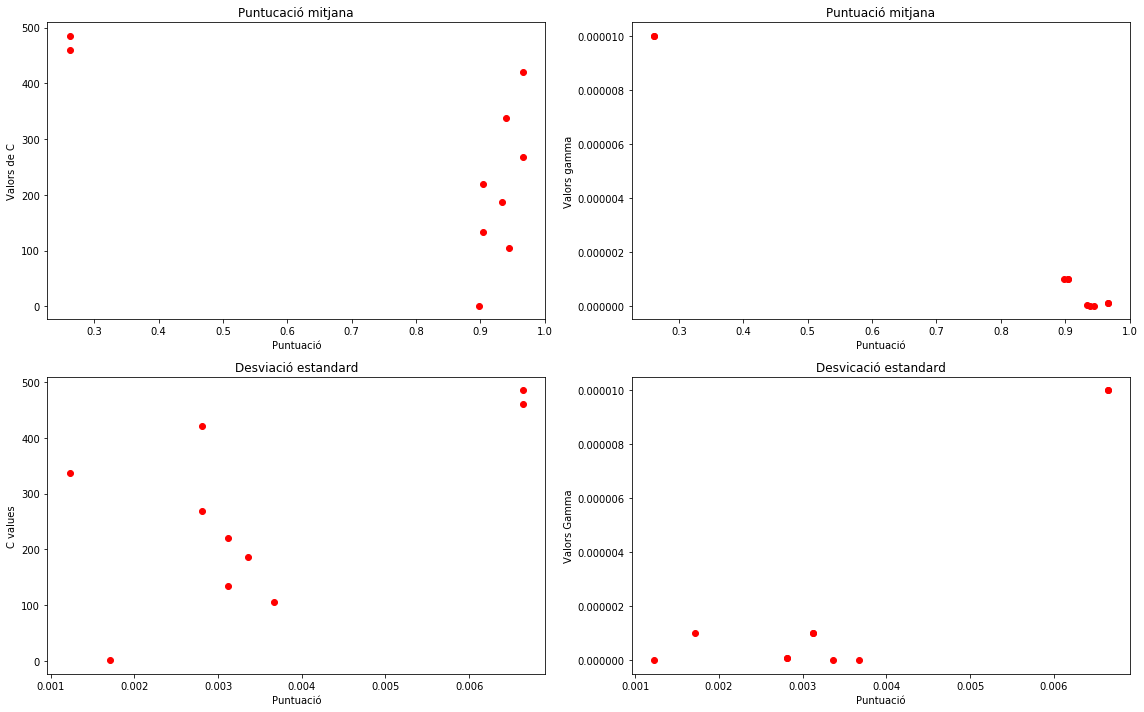

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(16, 10))


ax[0][0].plot(model_randomized_search_cv.cv_results_['mean_test_score'].tolist(), model_randomized_search_cv.cv_results_['param_C'].tolist(), 'ro')
ax[0][0].set_ylabel('Valors de C')
ax[0][0].set_xlabel('Puntuació')
ax[0][0].set_title('Puntucació mitjana')


ax[0][1].plot(model_randomized_search_cv.cv_results_['mean_test_score'].tolist(), model_randomized_search_cv.cv_results_['param_gamma'].tolist(), 'ro')
ax[0][1].set_ylabel('Valors gamma')
ax[0][1].set_xlabel('Puntuació')
ax[0][1].set_title('Puntuació mitjana')

ax[1][0].plot(model_randomized_search_cv.cv_results_['std_test_score'].tolist(), model_randomized_search_cv.cv_results_['param_C'].tolist(), 'ro')
ax[1][0].set_ylabel('C values')
ax[1][0].set_xlabel('Puntuació')
ax[1][0].set_title('Desviació estandard')

ax[1][1].plot(model_randomized_search_cv.cv_results_['std_test_score'].tolist(), model_randomized_search_cv.cv_results_['param_gamma'].tolist(), 'ro')
ax[1][1].set_ylabel('Valors Gamma')
ax[1][1].set_xlabel('Puntuació')
ax[1][1].set_title('Desvicació estandard')

plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> entrenar un model SVM amb els valors dels hiperparàmetres òptims utilitzant tot el conjunt *X_train_pca* i mostrar la precisió de la predicció del model en el conjunt *X_test_pca*.
</div>

Com a conclusió observem que el paràmetre gemma afecta en major part a l'increment del resultat del model, per tant en valors més alts més marge generem en el Kernel entre les capes i l'estimació es torna més conservadora, representat en els gràfics amb més distancia entre les mostres.

Per altra banda el paràmetre, C, no és massa significatiu amb comparació amb el paràmetre gamma, amb el gràfic podem observar que la mitjana no hi ha gaire diferència i de la desviació estàndard és manté constant, per tant, la millora no és significativa en modificar el paràmetre C i per contra poden estar especialitzant el model, overfiting.

In [12]:
from sklearn.metrics import accuracy_score

parameters = {
    'C':            np.arange( 1, 500+1, 1 ).tolist(),
    'kernel':       ['rbf'],
    'gamma':        np.logspace(-9, -5, 5).tolist()
}

model_randomized_PCA = RandomizedSearchCV(
            estimator           = svm.SVC(),
            param_distributions = parameters,
            n_iter              = 10
        )

model_randomized_PCA.fit(X_train_pca, y_train)

print( model_randomized_PCA.best_estimator_ )
print( model_randomized_PCA.best_score_ )
print( model_randomized_PCA.best_params_ )

SVC(C=58, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.96775
{'kernel': 'rbf', 'gamma': 1e-07, 'C': 58}


In [13]:
modelSVM = svm.SVC(kernel='rbf', gamma=model_randomized_PCA.best_params_['gamma'], C=model_randomized_PCA.best_params_['C']).fit(X_train_pca, y_train)
predict = modelSVM.predict(X_test_pca)

print ("La precisió del model SVM és ", (accuracy_score(y_test,predict)*100))

La precisió del model SVM és  97.5


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> mostrar la matriu de confusió del model i algunes imatges que el model hagi classificat incorrectament juntament amb l'etiqueta assignada pel model i l'etiqueta original.
</div>

[[196   2   0   1   1]
 [  3 188   2   4   3]
 [  0   0 198   0   2]
 [  1   1   0 198   0]
 [  1   0   3   1 195]]


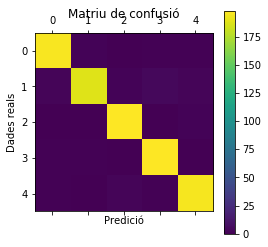

In [14]:
from sklearn.metrics import confusion_matrix
import pandas

cm = confusion_matrix(y_test, predict)
print(cm)

# representem graficament
plt.matshow(cm)
plt.title('Matriu de confusió')
plt.colorbar()
plt.ylabel('Dades reals')
plt.xlabel('Predició')
plt.show()

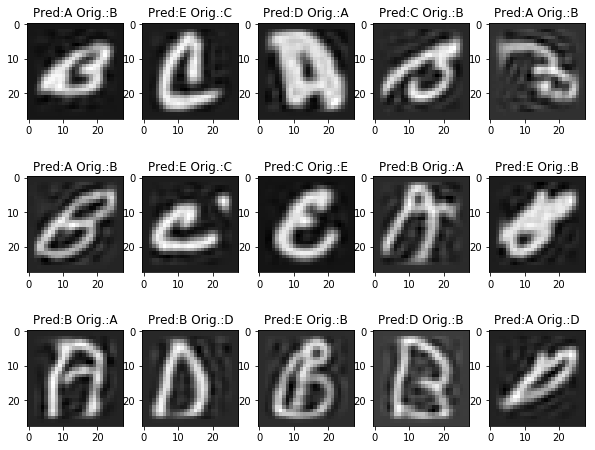

In [15]:
n_images = 5
fields = 3

fig, ax = plt.subplots(fields, n_images, figsize=(10, 8))

y = 0
x = 0
for i in range(predict.size):
    if predict[i] != y_test[i]:
        image = pca.inverse_transform(X_test_pca[i])
        ax[y][x].imshow(image.reshape(28, 28).transpose(), cmap="gray")
        ax[y][x].set_title("Pred:%s Orig.:%s" % (labels_text[predict[i]], labels_text[y_test[i]]))
        x = x + 1
        if x > n_images - 1:
            x = 0
            y = y + 1
        if y > fields - 1:
            break

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Com són els errors? Semblen raonables?
</div>

La reducció de dimensionalitat també ens redueix les possibilitats d'erros del model, podem veure respecte a la pregunta anterior que la perdició correcta augmenta d'un 95% fins a un 97%, i sols els casos realment complicats, on visualment és complicat fins i tot diferenciar, com podem veure en les imatges anteriors.

## 3. Xarxes neuronals (3 punts)

Per al tercer exercici utilitzarem una xarxa neuronal per a classificar les imatges de les lletres. Utilitzarem també ara una cerca aleatòria per ajustar els hiperparàmetres de la xarxa neuronal. En particular, utilitzarem una xarxa monocapa amb 5 sortides (una per a cada classe del conjunt de dades) entrenada amb el mètode de retropropagació i l'optimitzador SGD. Les neurones de la capa oculta trindran com a activació la funció sigmoide. Els hiperparàmetres a ajustar en aquest cas són els següents:

- Número de neurones de la capa oculta: provarem valors entre 20 y 1000.
- Número d'èpoques d'entrenament: provarem valors entre 10 y 150.
- Velocitat d'aprenentatge (learning rate): provarem valors entre 0.0001 y 0.2.

El procediment per a validar el rendiment del model per a cada combinació de paràmetres serà el mateix que en els casos anteriors: validació creuada amb 4 particions generades de forma estratificada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> càlcul del valor òptim del número de neurones de la capa oculta, el número d'èpoques d'entrenament i la velocitat d'aprenentatge utilitzant 10 combinacions de paràmetres triades a l'atzar. Podeu utilitzar els mòduls Sequential, Dense i SGD de keras, així com els mòduls uniform i randint de scipy i StratifiedKFold de sklearn.
</div>

Les capes completament connectades es defineixen mitjançant la classe Dense.

Podem especificar el nombre de neurones a la capa com el primer argument, el mètode d'inicialització com el segon argument com init i especifica la funció d'activació mitjançant l'argument d'activació.

Creem la funció per mostrar l'habilitat del model per a cada època. Es creen i avaluen la combinatòria de paràmetres amb el GridSearchCV i es mostra la precisió mitjana final amb el paràmetres que indica l'enunciat:

In [16]:
# MLP for Pima Indians Dataset with grid search via sklearn
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

num_classes = 5  # les 5 lletres de sortida

# preprocess dels labels
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)


# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, neurones=1, init='glorot_uniform'):
    # create model
    model = Sequential()
    # l'optimitzador SGD
    # https://keras.io/optimizers/
    optimizer = SGD(lr=learn_rate)
    # monocapa 5 sortides 
    # trindran com a activació la funció sigmoide
    model.add(Dense(neurones, input_dim=100, activation='sigmoid'))  # neurones entre 20 i 1000
    model.add(Dense(num_classes, init=init, activation='sigmoid'))  # 5 classes de sortida
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# grid search epochs
# https://keras.io/initializers/
init = ['RandomUniform']  # aleatori

# Número de neurones de la capa oculta: provarem valors entre 20 y 1000.
neurones = np.random.randint(20, 1000, size=3)

# Número d'èpoques d'entrenament: provarem valors entre 10 y 150.
epochs = np.random.randint(10, 150, size=3)

# Velocitat d'aprenentatge (learning rate): provarem valors entre 0.0001 y 0.2.
learning_rate = np.random.uniform(low=0.0002, high=0.2, size=(3,))

# split into input (X) and output (Y) variables
# 4 particions generades de forma estratificada.
kfold = StratifiedKFold(n_splits=4, random_state=999999, shuffle=True)
cv = list(kfold.split(X_train_pca, y_train))

param_grid = dict(learn_rate=learning_rate, neurones=neurones, init=init, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)

grid_result = grid.fit(X_train_pca, Y_train)


Using TensorFlow backend.


Best: 0.971300 using {'epochs': 35, 'init': 'RandomUniform', 'learn_rate': 0.10245252063921789, 'neurones': 999}
0.967300 (0.003910) with: {'epochs': 47, 'init': 'RandomUniform', 'learn_rate': 0.04318694731165299, 'neurones': 999}
0.967000 (0.003977) with: {'epochs': 47, 'init': 'RandomUniform', 'learn_rate': 0.04318694731165299, 'neurones': 581}
0.965150 (0.003907) with: {'epochs': 47, 'init': 'RandomUniform', 'learn_rate': 0.04318694731165299, 'neurones': 131}
0.968600 (0.003726) with: {'epochs': 47, 'init': 'RandomUniform', 'learn_rate': 0.051097520805986424, 'neurones': 999}
0.965850 (0.004122) with: {'epochs': 47, 'init': 'RandomUniform', 'learn_rate': 0.051097520805986424, 'neurones': 581}
0.966100 (0.003327) with: {'epochs': 47, 'init': 'RandomUniform', 'learn_rate': 0.051097520805986424, 'neurones': 131}
0.971000 (0.003672) with: {'epochs': 47, 'init': 'RandomUniform', 'learn_rate': 0.10245252063921789, 'neurones': 999}
0.970100 (0.004021) with: {'epochs': 47, 'init': 'RandomUn

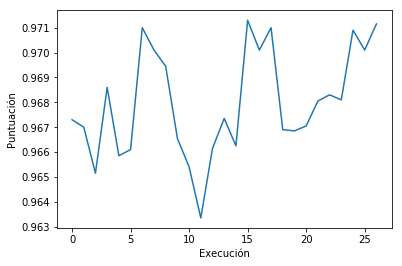

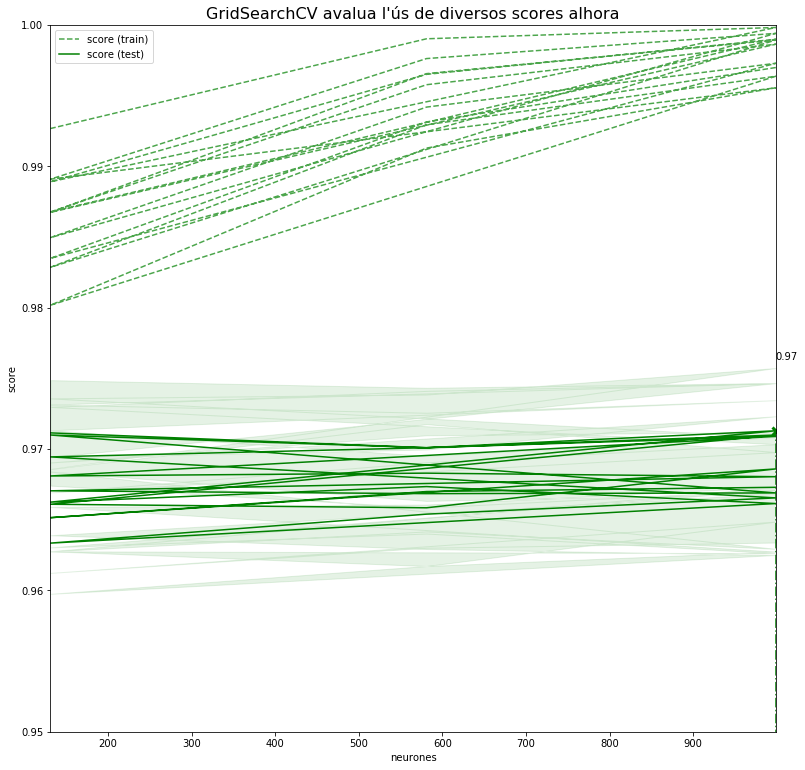

In [17]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print('=================================================')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.plot(means)
plt.ylabel('Puntuación')
plt.xlabel('Execución')
plt.show()

results = grid_result.cv_results_
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV avalua l'ús de diversos scores alhora", fontsize=16)

plt.xlabel("neurones")
plt.ylabel("score")
plt.grid()

ax = plt.axes()
ax.set_xlim(min(neurones),  max(neurones))
ax.set_ylim(0.95, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_neurones'].data, dtype=float)

for scorer, color in zip(sorted(['score']), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

El paràmetre que ha donat millor resultat és: 
Nombre de neurones de la capa oculta: Número d'èpoques d'entrenament: 999.
Número d'èpoques d'entrenament: 35.
Velocitat d'aprenentatge (learning rate): 0.10245252063921789.
Hem obtingut un score de 0.971300.


La diferència entre les combinacions com podem veure, en la gràfica i la llista, no és massa significativa, entre 96% i 97%. No hi ha cap paràmetres que canvi massa els resultats, potser ens faltaria realitzar mes combinacions, però si podem veure que com mes neurones, tot i que el grafic es confus, la puntuació d'encerts és més alta (despres de diverses execucions sempre el numero més alt de nuerones ha donat la millo puntuació), però amb el perill de *sobreentrenament*, era d'esperar.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> entrenar una xarxa neuronal amb els valors dels hiperparàmetres òptims utilitzant tot el conjunt *X_train_pca* i mostrar la precisió de la predicció del model en el conjunt *X_test_pca*.
</div>

In [18]:
model = Sequential()

# l'optimitzador SGD
# https://keras.io/optimizers/
optimizer = SGD(lr=0.1893983935452452)

# normalitze
Y_test = keras.utils.to_categorical(y_test, num_classes)

# monocapa 5 sortides 
# trindran com a activació la funció sigmoide
model.add(Dense(826, input_dim=100, activation='sigmoid'))  # neurones entre 20 i 1000
model.add(Dense(num_classes, init='RandomUniform', activation='sigmoid'))  # 5 classes de sortida

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train_pca, Y_train, epochs=54, verbose=0)  # Número d'èpoques d'entrenament 54
score = model.evaluate(X_test_pca, Y_test)

# predict the response
pred = model.predict(X_test_pca)

print('Test score:', score[0])
print('Test accuracy:', score[1])

1000/1000 [==============================] - 1s 928us/step
Test score: 0.057282451540231705
Test accuracy: 0.9804000072479248


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> mostrar la matriu de confusió del model i algunes imatges que el model hagi classificat incorrectament juntament amb l'etiqueta assignada pel model i l'etiqueta original.
</div>

[[193   2   1   1   3]
 [  4 181   3   6   6]
 [  2   0 197   1   0]
 [  1   3   1 195   0]
 [  0   2   3   2 193]]


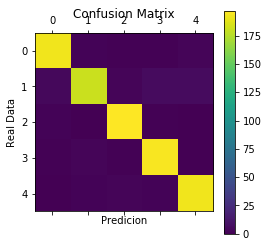

We print some of the images that have not been correctly classified


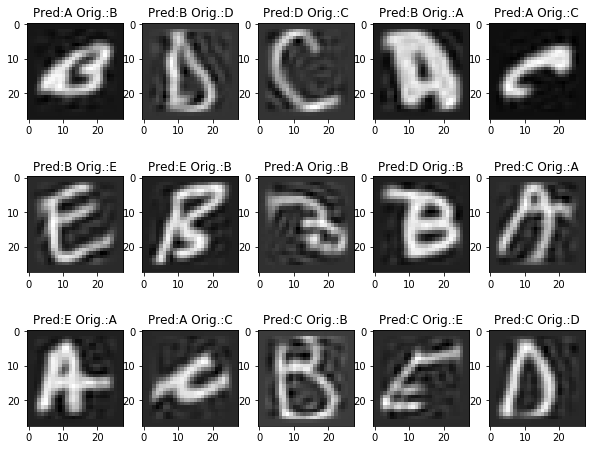

In [19]:
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np

axis_1_y = Y_test.argmax(axis=1)
axis_1_p = pred.argmax(axis=1)

cm = confusion_matrix(
    axis_1_y,
    axis_1_p
)
print(cm)

# representem graficament
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('Real Data')
plt.xlabel('Predicion')
plt.show()

Error_list_index = [i for i, (j, k) in enumerate(zip(axis_1_y, axis_1_p)) if j != k]

print('We print some of the images that have not been correctly classified')

n_images = 5
fields = 3

fig, ax = plt.subplots(fields, n_images, figsize=(10, 8))

for y in range(fields):
    x = 0
    for i in range(y * n_images, y * n_images + (n_images)):
        k = Error_list_index[i]
        image = pca.inverse_transform(X_test_pca[k])
        ax[y][x].imshow(image.reshape(28, 28).transpose(), cmap="gray")
        ax[y][x].set_title("Pred:%s Orig.:%s" % (labels_text[axis_1_p[k]], labels_text[axis_1_y[k]]))
        x = x + 1

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Com són els errors? Semblen raonables?
</div>

Com ja ens ha passat abans amb el SVN, la reducció de dimensionalitat també ens redueix les possibilitats d'erros del model, podem veure respecte a la pregunta anterior que la perdició correcta augmentat molt poc, com abans sols els casos realment complicats, on visualment és complicat fins i tot diferenciar, han donat error.

## 4. Aprenentatge no supervisat amb xarxes neuronals (3 punts)

Després del ressorgiment de les xarxes neuronals s'han produit diversos avenços en l'àrea de l'aprenentatge no supervisat. Una de les aplicacions principals en aquest sentit són els autoencoders. La intuició darrera un autoencoder clàssic és **aprendre una representació més compacta de l'entrada** tractant de reconstruir-la a la sortida.

Un autoencoder consisteix en una xarxa neuronal monocapa on el número de neuronas a la sortida coincideix amb el número de neurones a l'entrada, mentre que la capa oculta conté menys neuronas. Després d'entrenar una xarxa d'aquest estil es pot utilitzar la sortida, per exemple, per [eliminar soroll](https://www.doc.ic.ac.uk/~js4416/163/website/autoencoders/denoising.html), però la seva capa central també té interès perquè és una representació "compacta" de l'entrada que ha après a extraure la informació essencial per a maximitzar l'èxit en la reconstrucció.

<div style="float:left; margin: 20px;">
<img src="http://ufldl.stanford.edu/tutorial/images/Autoencoder636.png" alt="Esquema d'Autoencoder" style="height: 400px;"/>
<p style="margin: 0; text-align:center;">Fig. 1. Esquema d'autoencoder</p>
</div>
<div style="margin: 20px;">
<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" alt="Exemple Autoencoder" style="height: 150px;"/>
<p style="margin: 0; text-align:center;">Fig. 2. Exemple d'autoencoder</p>
</div>

Tal i com es pot veure a la figura 2, la capa o capes que porten fins a la representació compacta s'anomenen *Encoder*, i la part que va des de la representació compacta fins a la sortida s'anomenta *Decoder*.

En aquest exercici utilitzarem un autoencoder amb 2 neurones a la capa central per a obtenir una representació en dues dimensions de les series temporals corresponents al preu de diferents criptomonedes. Això ens permetrà mostrar la representació compacta de les criptomonedes en un pla i clusteritzar visualment aquelles criptomonedes que hagin tingut un comportament similar al llarg del temps.

El següent codi descarrega la informació de les criptomonedes. Concretament, utilitzem l'[*API* de cryptocompare](https://www.cryptocompare.com/api/) per a descarregar el preu de tancament de cada dia durant l'últim any de 100 criptomonedes.

In [20]:
import json
import requests

N_DAYS = 365
N_COINS = 100

# Get coin list.
response = requests.get('https://www.cryptocompare.com/api/data/coinlist/')
coins = [k for k, v in json.loads(response.text)['Data'].items() if int(v['SortOrder']) <= N_COINS]

# Get daily @ close for each coin.
series = {}
for coin in coins:
    try:
        response = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym=USD&limit={}&e=CCCAGG'.format(coin, N_DAYS - 1))
        data = json.loads(response.text)['Data']
        if (len(data) == N_DAYS and all(t < 100000 for t in [d['close'] for d in data])):
            series[coin] = [x['close'] for x in data]
            print(coin, end=' ')
        else:
            print('*{}*'.format(coin), end=' ')
    except:
        print('*{}*'.format(coin), end=' ')

DOGE ZEC BTS DGB BTCD CRAIG XPY PRC *YBC* DANK GIVE KOBO DT CETI SUP XPD GEO CHASH SPR NXTI WOLF XDP 2015 *42* AC ALF AGS AMC ALN ARI AUR AXR BCX BEN BITB BLU BLK BOST BQC XMY MOON ZET ENRG QRK RIC DGC CAIX BTG* BUK CACH CANN CAP CASH CCN CINNI CLAM CLOAK CLR CMC CNC CNL COMM COOL CRACK *CRC** CRYPT DEM ARG BTM PPC ACOIN AERO APEX ARCH BET QTL LIMX BTB BTE CIN CXC DRKC XBS DMD CAT1 XVG SXC BTC CSC XRP LTC DASH CBX ETC ETH NXT XMR 

Amb el següent codi podem veure la informació descarregada per a cada moneda en un únic gràfic.

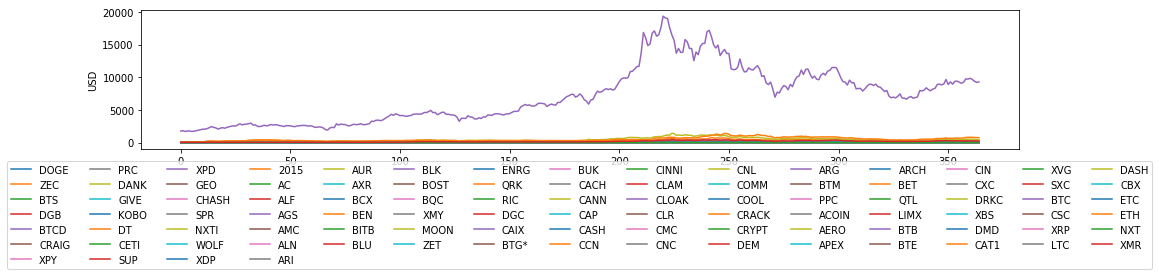

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for k, v in series.items():
    ax.plot(range(len(v)), v, label=k)
    ax.set_ylabel('USD')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=15)
plt.tight_layout()

A la gràfica anterior s'observa com poques monedes (com BTC, Bitcoin) tenen valors molt alts en USD (milers de dòlars), però la majoria tenen poc valor (típicament cèntims). Per trobar similituts entre sèries amb independència de l'escala (i per a facilitat l'entrenament de l'autoencoder) és bona idea normalitzar les sèries.

Amb el següent codi primer normalitzem les sèries dividint cada valor pel màxim de la sèrie i tornem a mostrar la gràfica.

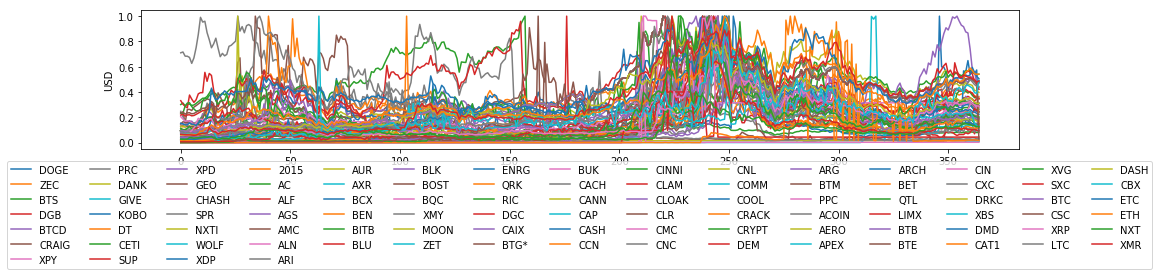

In [22]:
series_norm = {k: np.array(v) / max(v) for k, v in series.items()}

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for k, v in series_norm.items():
    ax.plot(range(len(v)), v, label=k)
    ax.set_ylabel('USD')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=15)
plt.tight_layout()

A continuació crearem l'autoencoder utilitzant una capa d'entrada amb tantes neurones com dies tenim d'informació, una capa central amb dues neurones per a facilitat la visualització de les dades comprimides i una capa de sortida amb el mateix número de neurones que la capa d'entrada. Per a aquest exercici utilitzarem neurones amb la tangent hiperbòlica com a funció d'activació.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Construir i entrenar l'autoencoder tenint present que en el següent exercici necessitarem poder accedir als resultats de la capa central. Podeu utilitzar els mòduls Model, Input i Dense de Keras.
</div>

In [23]:
from keras.layers import Input, Dense
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')

# Realitzem la transformació dels inputsa un array per al model de xarxa neuronal.
coinsArray = []
for key in series_norm.keys():
    coinsArray.append(series_norm[key])
    
coinsArray = np.array(coinsArray)

# El parametre de entrada correspont al dies d'històric de dades que disposem uns 365 dies
input_img = Input(shape=(N_DAYS,))

# Capa central amb 2 neurones agregan el parametre de entrada.
encoded = Dense(2, activation='tanh')(input_img)

# El nostra objectiu en aquest cas es accedir als resultat de la capa central
encoder = Model(input_img, encoded)

encodedCoins = encoder.predict(coinsArray)

Per a obtenir la representació compacta de les sèries temporals és necessari invocar el mètode [predict](https://keras.io/models/model/#predict) de l'encoder y alimentar-lo amb cada sèrie temporal normalitzada.

L'*embedding* (sortida de l'encoder) de les sèries temporals tindrà 2 dimensions, pel que es pot visualitzar mitjançant un *scatter plot* bidimensional.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Obtenir la representació compacta de cada sèries temporal i visualitzar cada moneda en un <i>scatter plot</i> de forma que es pugui identificar cada punt (jugant amb el color i marcador) amb el nom de la criptomoneda corresponent a través de la llegenda.
</div>

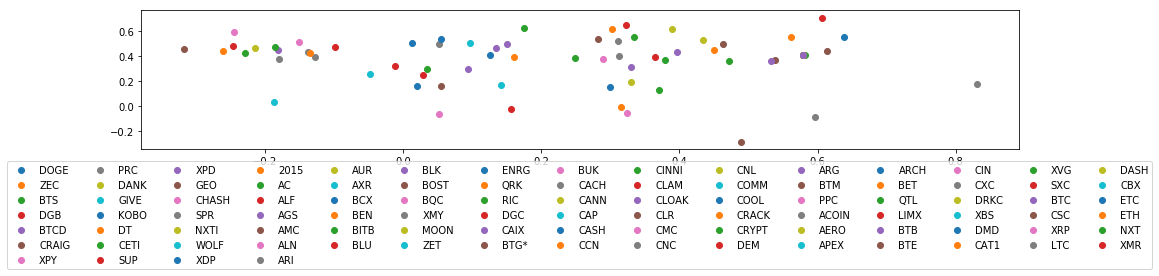

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for k, v in zip(series_norm.keys(), encodedCoins):
    ax.scatter(v[0], v[1], label=k)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=15)
plt.tight_layout()

Una manera d'entedre el que ha après l'autoencoder és visualitzar sèries originals de les monedes que es troben properes en la representació compacta. Visualitzant les sèries properes és possible fer-se una idea del que representa cada punt de l'espai gràcies a les característiques comuns del grup de sèries.

D'altra banda, explorar diferents grups al llarg de l'espai permet comprendre millor la implicació de les dimensions apreses.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació y anàlisi:</strong> Seleccionar 3 grups de punts diferents al llarg de tot l'espai i visualitzar les seves sèries. Analitzar els grups i les seves diferències per intentar donar una interpretació a cadascuna de les dimensions.
</div>

In [25]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

# Com en el pas anterior
# Realitzem la transformació dels inputsa un array per al model de xarxa neuronal.
input_days = Input(shape=(N_DAYS,))

# Capa central amb 2 neurones agregan el parametre de entrada.
encoded = Dense(2, activation='tanh')(input_days)

# Ara si construïm la capa de sortida amb les 265 neurones 
# per a realitzar el decoder.
decoded = Dense(
    N_DAYS,
    kernel_initializer='random_uniform',
    bias_initializer='zeros',
    activation='tanh'
)(encoded)

# Construcció del model.
auto_encoder = Model(input_days, decoded)
epochs = np.random.randint(100, 150)

#Despres de varies probes, el optimitze amb algorimes Adam i 
# i perdua mean_squared_error ens a donat uns bons resultats
auto_encoder.compile(optimizer='Adam', loss='mean_squared_error', metrics=['accuracy'])
auto_encoder.fit(
    coinsArray,
    coinsArray,
    epochs=epochs,
    verbose=0,
    validation_data=(coinsArray, coinsArray)
)

re_EncodedCoins = auto_encoder.predict(coinsArray)

In [26]:
# A nivell orientatiu podem veure una aproximació
print(coinsArray[0][1])
print(re_EncodedCoins[0][1])

0.07205882352941176
0.08339823


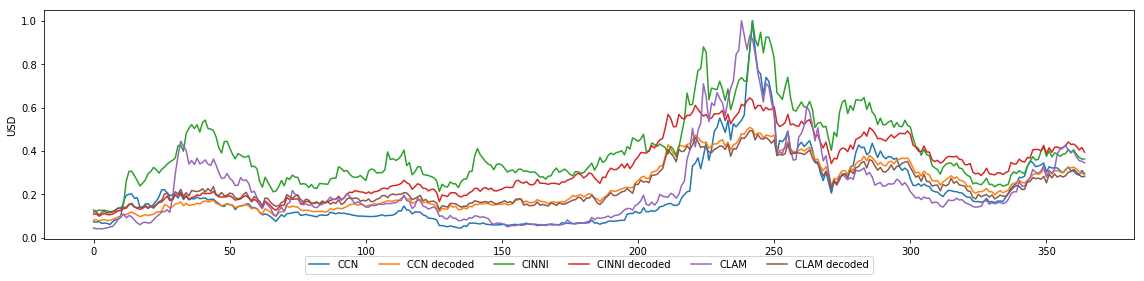

In [27]:
coin_keys_group = ['CCN', 'CINNI', 'CLAM']

iterator = 0
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for coin_key in coin_keys_group:
    ax.plot(range(len(coinsArray[iterator])), coinsArray[iterator], label=coin_key)
    ax.plot(range(len(re_EncodedCoins[iterator])), re_EncodedCoins[iterator], label=coin_key + " decoded")
    ax.set_ylabel('USD')
    iterator = iterator + 1

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=15)
plt.tight_layout()

Pel que podem veure la distribució dels valors de les monedes, tant en les dades originals com les codificades, seguen la mateixa tendència, inclús podem veure que la pròxima és molt bona, ja que hem passat de 365 a 2 dimensions, i un altre cop a les 365, i la pèrdua, tot i que visible, no significativa per la distribució.

Si entrenem més el model, l'aproximació serà més alta, si hem pogut veure que depenen els paràmetres: epochs i optimize, el resultat canvio bastant.

# Bibliografia
* https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
* http://scikit-learn.org/stable/modules/svm.html
* https://keras.io/optimizers/
* https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/
* https://keras.io/layers/core/
* https://stackoverflow.com/questions/46440273/error-in-getting-confusion-matrix
* https://faroit.github.io/keras-docs/0.3.0/examples/
* https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc
* https://keras.io/initializers/